In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import requests  # HTTP library for Python
import bs4
import math
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import gsw
%matplotlib inline
import os
import sys
import xmitgcm 
#import xgcm
#import pyproj
#import wget
#sys.path.append('../../ECCOv4-py/ECCOv4-py')
#import ecco_v4_py as ecco
import cmocean
sys.path.append('../cape_mend_SM_LCS/datatools')
import datatools as tools
plt.rcParams['text.usetex'] = False
import warnings
warnings.filterwarnings('ignore')
sys.path.append("matlab22aPy39\Lib\site-packages")

from scipy.interpolate import griddata

from tqdm.notebook import tqdm
import scipy.io
import mat73
#import matlab.engine
import matlab.engine
import airsea


<>:28: SyntaxWarning: invalid escape sequence '\L'
<>:28: SyntaxWarning: invalid escape sequence '\L'
C:\Users\basil\AppData\Local\Temp\ipykernel_30544\619455292.py:28: SyntaxWarning: invalid escape sequence '\L'
  sys.path.append("matlab22aPy39\Lib\site-packages")


In [2]:
eng = matlab.engine.start_matlab()


In [3]:
eng.addpath("C:/Users/basil/OneDrive/Desktop/ERA5_project/NAVSLaM/NAVSLaM")

'C:\\Users\\basil\\OneDrive\\Documents\\MATLAB;C:\\Program Files\\MATLAB\\R2024b\\toolbox\\matlab\\addon_enable_disable_management\\matlab;C:\\Program Files\\MATLAB\\R2024b\\toolbox\\matlab\\addon_updates\\matlab;C:\\Program Files\\MATLAB\\R2024b\\toolbox\\matlab\\addons;C:\\Program Files\\MATLAB\\R2024b\\toolbox\\matlab\\addons\\cef;C:\\Program Files\\MATLAB\\R2024b\\toolbox\\matlab\\addons\\fileexchange;C:\\Program Files\\MATLAB\\R2024b\\toolbox\\matlab\\addons\\supportpackages;C:\\Program Files\\MATLAB\\R2024b\\toolbox\\matlab\\addons_common\\matlab;C:\\Program Files\\MATLAB\\R2024b\\toolbox\\matlab\\addons_desktop_registration;C:\\Program Files\\MATLAB\\R2024b\\toolbox\\matlab\\addons_install_location\\matlab;C:\\Program Files\\MATLAB\\R2024b\\toolbox\\matlab\\addons_product;C:\\Program Files\\MATLAB\\R2024b\\toolbox\\matlab\\addons_product_support\\matlab;C:\\Program Files\\MATLAB\\R2024b\\toolbox\\matlab\\addons_registry\\matlab;C:\\Program Files\\MATLAB\\R2024b\\toolbox\\matlab\

In [2]:
var_names = ['crrmmphr_sa', 'crrmmphr_sa_time', 'hghcldcov_sa', 'hghcldcov_sa_time', 'ilspf_sa', 'ilspf_sa_time', 'lowcldcov_sa', 'lowcldcov_sa_time', 'lsrrmmphr_sa', 'lsrrmmphr_sa_time', 'medcldcov_sa', 'medcldcov_sa_time', 'mslpmbar_sa', 'mslpmbar_sa_time', 'pmbar_sa', 'pmbar_sa_time', 'qair_ha_001_001', 'qair_ha_001_001_time', 'ssrdjperm2_sa', 'ssrdjperm2_sa_time', 'sstc_sa', 'sstc_sa_time', 'sswhm_sa', 'sswhm_sa_time', 'swhm_sa', 'swhm_sa_time', 'swwhm_sa', 'swwhm_sa_time', 'tairc_2ma', 'tairc_2ma_time', 'tairc_ha_001_001', 'tairc_ha_001_001_time', 'tcldcov_sa', 'tcldcov_sa_time', 'tdewc_2ma', 'tdewc_2ma_time', 'total1hrprecipm_sa', 'total1hrprecipm_sa_time', 'tskinc_sa', 'tskinc_sa_time', 'umps_10ma', 'umps_10ma_time', 'vmps_10ma', 'vmps_10ma_time']

In [3]:
def minutes_to_degrees(degrees,minutes):
    decimal_degrees = degrees + (minutes / 60)
    return decimal_degrees
I_ORS = [32, 7.380, 125, 10.944]
G_ORS = [33, 56.514, 124, 35.568]
S_ORS = [37, 25.386, 124, 44.286]


I_ORS_lat = minutes_to_degrees(I_ORS[0],I_ORS[1])
I_ORS_lon = minutes_to_degrees(I_ORS[2],I_ORS[3])

G_ORS_lat = minutes_to_degrees(G_ORS[0],G_ORS[1])
G_ORS_lon = minutes_to_degrees(G_ORS[2],G_ORS[3])


S_ORS_lat = minutes_to_degrees(S_ORS[0],S_ORS[1])
S_ORS_lon = minutes_to_degrees(S_ORS[2],S_ORS[3])


In [4]:
air_temp_10_files, air_temp_10_filepaths = tools.get_data_paths_from_binary('D:/era5_data/','era5_data_nc/tairc_ha_001_001/',file_end='nc')
skin_temp_files, skin_temp_filepaths = tools.get_data_paths_from_binary('D:/era5_data/','era5_data_nc/tskinc_sa/',file_end='nc')

air_temp_10 = xr.open_mfdataset(air_temp_10_filepaths)
skin_temp = xr.open_mfdataset(skin_temp_filepaths)

In [5]:
SST_files, SST_filepaths = tools.get_data_paths_from_binary('D:/era5_data/','era5_data_nc/sstc_sa/',file_end='nc')
SST_temp = xr.open_mfdataset(SST_filepaths)

In [11]:
SST_temp

<xarray.Dataset> Size: 3GB
Dimensions:  (time: 245448, lat: 42, lon: 40)
Coordinates:
  * time     (time) datetime64[ns] 2MB 1996-01-01 ... 2023-12-31T23:00:00
  * lat      (lat) float64 336B 37.52 37.24 36.96 36.67 ... 26.56 26.28 26.0
  * lon      (lon) float64 320B 118.7 119.0 119.2 119.5 ... 129.1 129.4 129.7
Data variables:
    SST      (time, lat, lon) float64 3GB dask.array<chunksize=(744, 42, 40), meta=np.ndarray>

In [6]:
land_mask = np.isfinite(SST_temp['SST'].isel(time=slice(0,100)).mean(dim='time',skipna=True))


In [7]:
air_sea_temp_diff = (air_temp_10['tairc_ha_001_001'] - skin_temp['tskinc_sa']).rename('airsea_temp_diff')

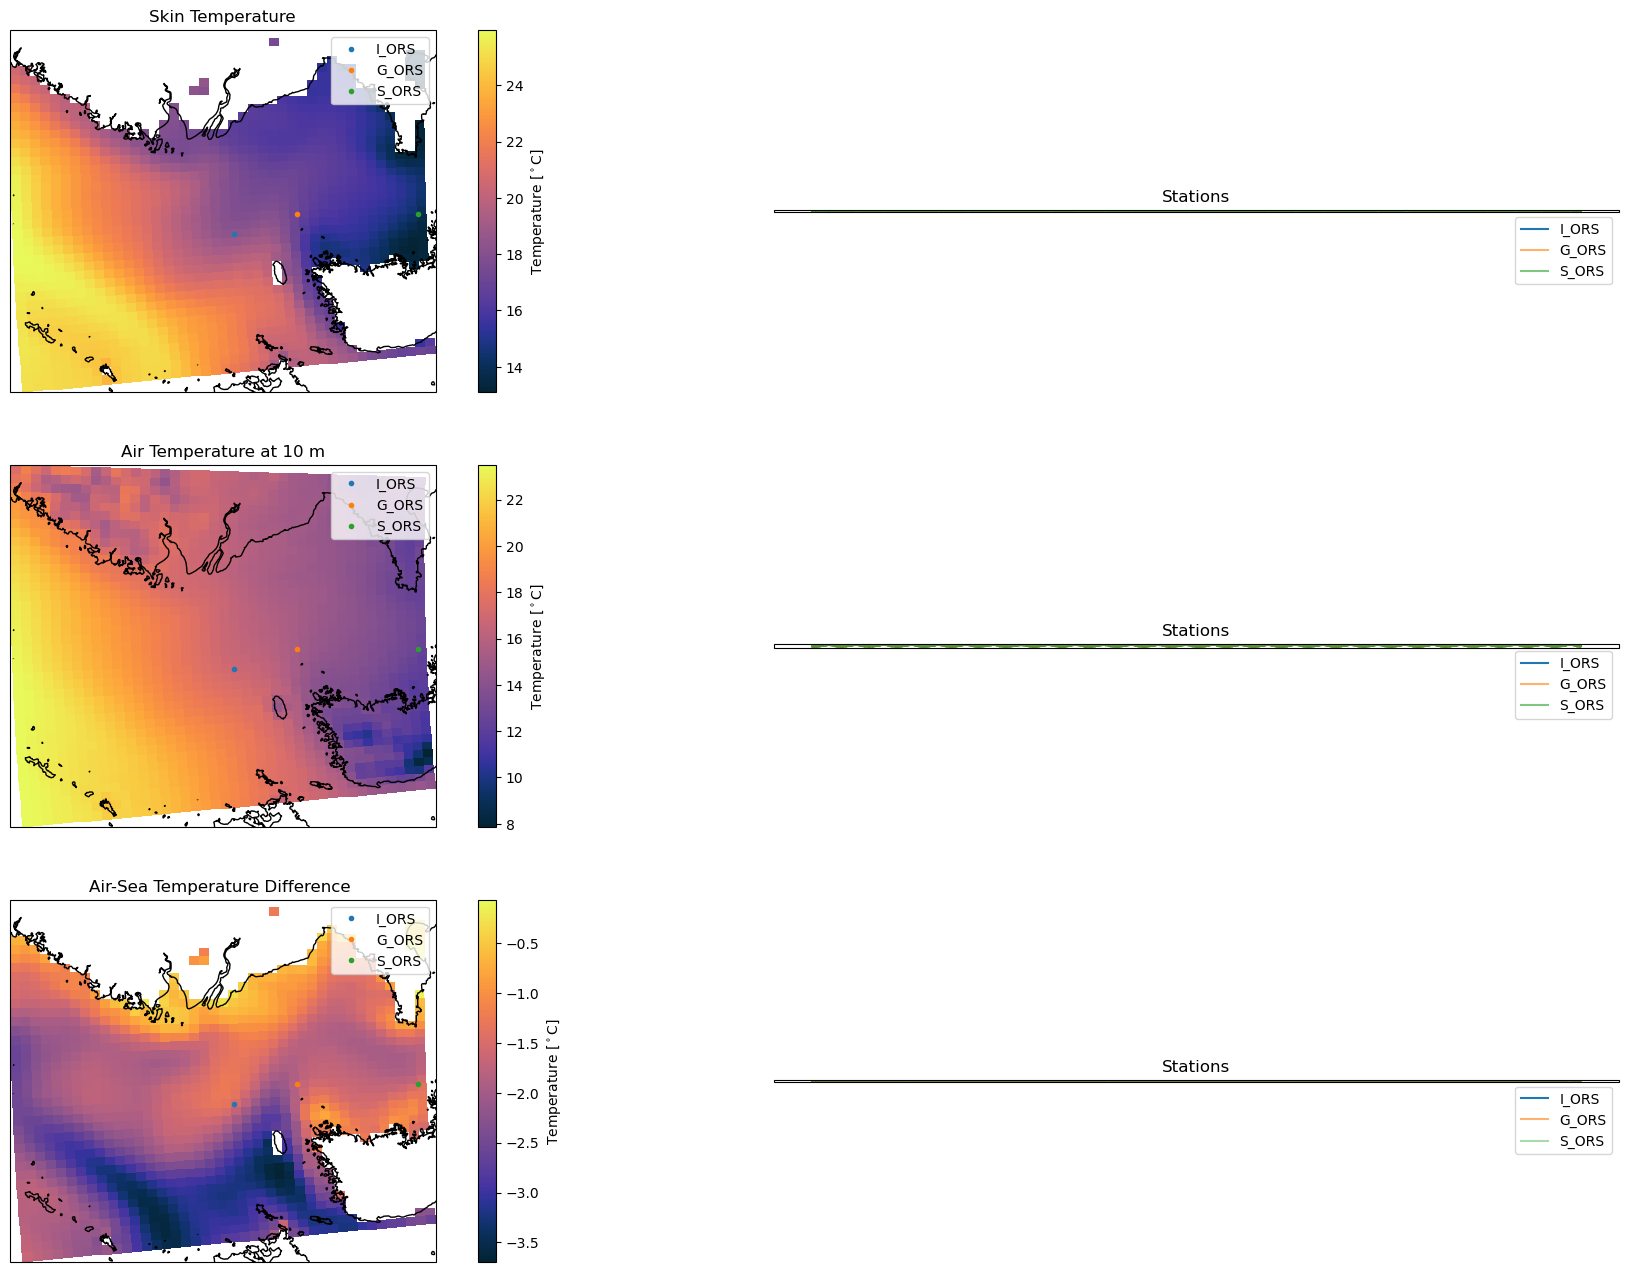

In [10]:
fig,ax = plt.subplots(ncols=2, nrows=3,figsize=(24,16),subplot_kw=dict(projection=ccrs.LambertConformal()))




labelz_temp = 'Temperature [$^\circ$C]'
#skin temp
skin_temp['tskinc_sa'].mean(dim='time',skipna=True).where(land_mask).plot(ax=ax[0,0],cmap=cmocean.cm.thermal,cbar_kwargs={'label':labelz_temp},transform=ccrs.PlateCarree())
ax[0,0].plot(I_ORS_lon,I_ORS_lat,'.',label='I_ORS',transform=ccrs.PlateCarree())
ax[0,0].plot(G_ORS_lon,G_ORS_lat,'.',label='G_ORS',transform=ccrs.PlateCarree())
ax[0,0].plot(S_ORS_lon,S_ORS_lat,'.',label='S_ORS',transform=ccrs.PlateCarree())
ax[0,0].set_title('Skin Temperature')
ax[0,0].set_xlabel('Longitude')
ax[0,0].set_ylabel('Latitude')
ax[0,0].legend()

skin_temp['tskinc_sa'].sel(lon=I_ORS_lon,lat=I_ORS_lat,method='nearest').plot(ax=ax[0,1],label='I_ORS')
skin_temp['tskinc_sa'].sel(lon=G_ORS_lon,lat=G_ORS_lat,method='nearest').plot(ax=ax[0,1],label='G_ORS',alpha=.6)
skin_temp['tskinc_sa'].sel(lon=S_ORS_lon,lat=S_ORS_lat,method='nearest').plot(ax=ax[0,1],label='S_ORS',alpha=.6)
ax[0,1].set_ylabel(labelz_temp)
ax[0,1].legend()

ax[0,1].set_title('Stations')

#air temp

air_temp_10['tairc_ha_001_001'].mean(dim='time',skipna=True).plot(ax=ax[1,0],cmap=cmocean.cm.thermal,cbar_kwargs={'label':labelz_temp},transform=ccrs.PlateCarree())
ax[1,0].plot(I_ORS_lon,I_ORS_lat,'.',label='I_ORS',transform=ccrs.PlateCarree())
ax[1,0].plot(G_ORS_lon,G_ORS_lat,'.',label='G_ORS',transform=ccrs.PlateCarree())
ax[1,0].plot(S_ORS_lon,S_ORS_lat,'.',label='S_ORS',transform=ccrs.PlateCarree())
ax[1,0].set_title('Air Temperature at 10 m')
ax[1,0].set_xlabel('Longitude')
ax[1,0].set_ylabel('Latitude')
ax[1,0].legend()

ax[1,1].set_title('Stations')


air_temp_10['tairc_ha_001_001'].sel(lon=I_ORS_lon,lat=I_ORS_lat,method='nearest').plot(ax=ax[1,1],label='I_ORS')
air_temp_10['tairc_ha_001_001'].sel(lon=G_ORS_lon,lat=G_ORS_lat,method='nearest').plot(ax=ax[1,1],label='G_ORS',alpha=.6)
air_temp_10['tairc_ha_001_001'].sel(lon=S_ORS_lon,lat=S_ORS_lat,method='nearest').plot(ax=ax[1,1],label='S_ORS',alpha=.6)
ax[1,1].set_ylabel(labelz_temp)
ax[1,1].legend()

#air-sea temp diff

air_sea_temp_diff.mean(dim='time',skipna=True).where(land_mask).plot(ax=ax[2,0],cmap=cmocean.cm.thermal,cbar_kwargs={'label':labelz_temp},transform=ccrs.PlateCarree())
ax[2,0].plot(I_ORS_lon,I_ORS_lat,'.',label='I_ORS',transform=ccrs.PlateCarree())
ax[2,0].plot(G_ORS_lon,G_ORS_lat,'.',label='G_ORS',transform=ccrs.PlateCarree())
ax[2,0].plot(S_ORS_lon,S_ORS_lat,'.',label='S_ORS',transform=ccrs.PlateCarree())
ax[2,0].set_title('Air-Sea Temperature Difference ')
ax[2,0].set_xlabel('Longitude')
ax[2,0].set_ylabel('Latitude')
ax[2,0].legend()



air_sea_temp_diff.sel(lon=I_ORS_lon,lat=I_ORS_lat,method='nearest').plot(ax=ax[2,1],label='I_ORS')
air_sea_temp_diff.sel(lon=G_ORS_lon,lat=G_ORS_lat,method='nearest').plot(ax=ax[2,1],label='G_ORS',alpha=.6)
air_sea_temp_diff.sel(lon=S_ORS_lon,lat=S_ORS_lat,method='nearest').plot(ax=ax[2,1],label='S_ORS',alpha=.4)
ax[2,1].set_ylabel(labelz_temp)
ax[2,1].legend()
ax[1,1].set_title('Stations')

ax[2,1].set_title('Stations')

ax[0,0].coastlines()
ax[1,0].coastlines()
ax[2,0].coastlines()


plt.show()

In [11]:
zlabel = 'Temperature [$^\circ$C]'
air_sea_temp_diff.mean(dim='time',skipna=True).plot(cbar_kwargs={'label':zlabel})
plt.title('Air Sea Temperature Difference (air - skin)')
plt.show()

NameError: name 'labelz' is not defined

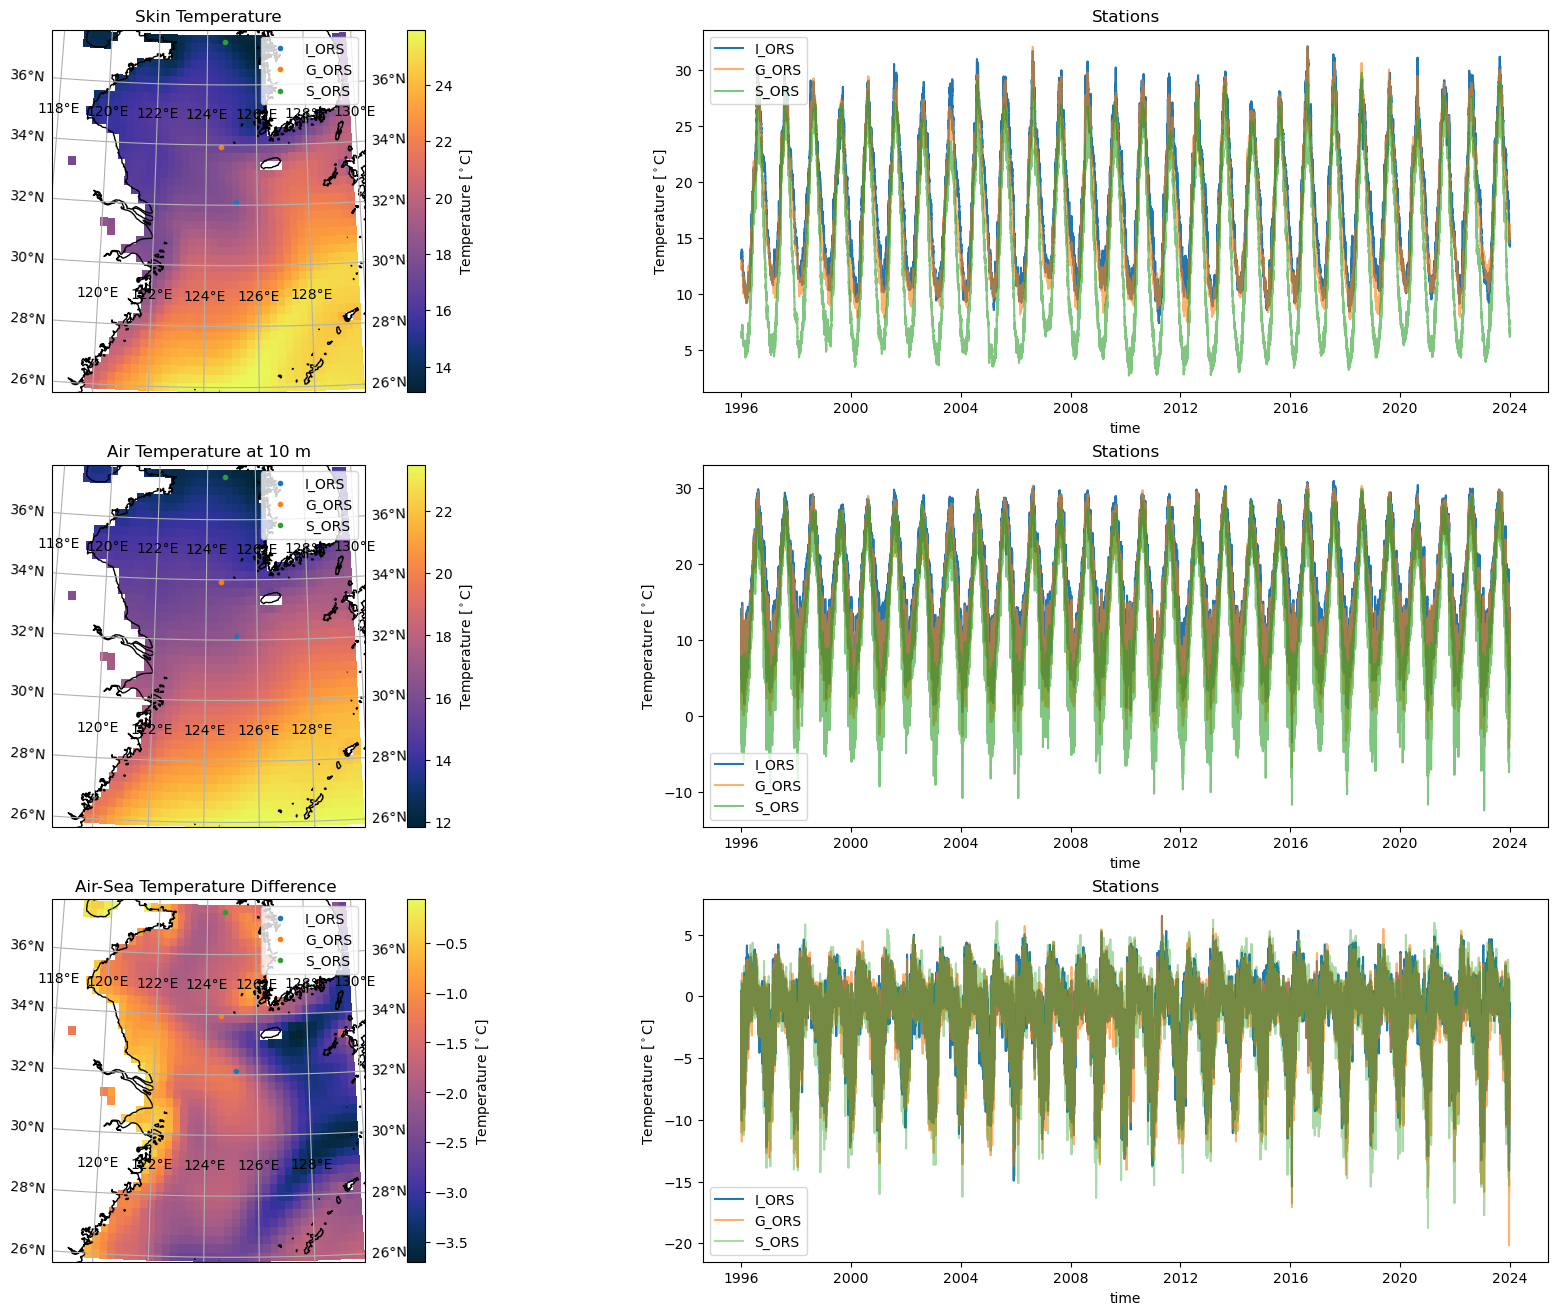

In [11]:
#Jan

plt.figure(figsize=(24,16))

ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=1,projection=ccrs.LambertConformal(central_longitude=125))
labelz_temp = 'Temperature [$^\circ$C]'
#skin temp
skin_temp['tskinc_sa'].mean(dim='time',skipna=True).where(land_mask).plot(ax=ax1,cmap=cmocean.cm.thermal,cbar_kwargs={'label':labelz_temp},transform=ccrs.PlateCarree())
ax1.plot(I_ORS_lon,I_ORS_lat,'.',label='I_ORS',transform=ccrs.PlateCarree())
ax1.plot(G_ORS_lon,G_ORS_lat,'.',label='G_ORS',transform=ccrs.PlateCarree())
ax1.plot(S_ORS_lon,S_ORS_lat,'.',label='S_ORS',transform=ccrs.PlateCarree())
ax1.set_title('Skin Temperature')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.legend()


ax2 = plt.subplot2grid((3, 2), (0, 1), colspan=1)
skin_temp['tskinc_sa'].sel(lon=I_ORS_lon,lat=I_ORS_lat,method='nearest').plot(ax=ax2,label='I_ORS')
skin_temp['tskinc_sa'].sel(lon=G_ORS_lon,lat=G_ORS_lat,method='nearest').plot(ax=ax2,label='G_ORS',alpha=.6)
skin_temp['tskinc_sa'].sel(lon=S_ORS_lon,lat=S_ORS_lat,method='nearest').plot(ax=ax2,label='S_ORS',alpha=.6)
ax2.set_ylabel(labelz_temp)
ax2.legend()

ax2.set_title('Stations')


ax3 = plt.subplot2grid((3, 2), (1, 0), colspan=1,projection=ccrs.LambertConformal(central_longitude=125))
air_temp_10['tairc_ha_001_001'].mean(dim='time',skipna=True).where(land_mask).plot(ax=ax3,cmap=cmocean.cm.thermal,cbar_kwargs={'label':labelz_temp},transform=ccrs.PlateCarree())
ax3.plot(I_ORS_lon,I_ORS_lat,'.',label='I_ORS',transform=ccrs.PlateCarree())
ax3.plot(G_ORS_lon,G_ORS_lat,'.',label='G_ORS',transform=ccrs.PlateCarree())
ax3.plot(S_ORS_lon,S_ORS_lat,'.',label='S_ORS',transform=ccrs.PlateCarree())
ax3.set_title('Air Temperature at 10 m')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
ax3.legend()


ax4 = plt.subplot2grid((3, 2), (1, 1), colspan=1)
ax4.set_title('Stations')


air_temp_10['tairc_ha_001_001'].sel(lon=I_ORS_lon,lat=I_ORS_lat,method='nearest').plot(ax=ax4,label='I_ORS')
air_temp_10['tairc_ha_001_001'].sel(lon=G_ORS_lon,lat=G_ORS_lat,method='nearest').plot(ax=ax4,label='G_ORS',alpha=.6)
air_temp_10['tairc_ha_001_001'].sel(lon=S_ORS_lon,lat=S_ORS_lat,method='nearest').plot(ax=ax4,label='S_ORS',alpha=.6)
ax4.set_ylabel(labelz_temp)
ax4.legend()

ax5 = plt.subplot2grid((3, 2), (2, 0), colspan=1,projection=ccrs.LambertConformal(central_longitude=125))
air_sea_temp_diff.mean(dim='time',skipna=True).where(land_mask).plot(ax=ax5,cmap=cmocean.cm.thermal,cbar_kwargs={'label':labelz_temp},transform=ccrs.PlateCarree())
ax5.plot(I_ORS_lon,I_ORS_lat,'.',label='I_ORS',transform=ccrs.PlateCarree())
ax5.plot(G_ORS_lon,G_ORS_lat,'.',label='G_ORS',transform=ccrs.PlateCarree())
ax5.plot(S_ORS_lon,S_ORS_lat,'.',label='S_ORS',transform=ccrs.PlateCarree())
ax5.set_title('Air-Sea Temperature Difference ')
ax5.set_xlabel('Longitude')
ax5.set_ylabel('Latitude')
ax5.legend()


ax6 = plt.subplot2grid((3, 2), (2, 1), colspan=1)
air_sea_temp_diff.sel(lon=I_ORS_lon,lat=I_ORS_lat,method='nearest').plot(ax=ax6,label='I_ORS')
air_sea_temp_diff.sel(lon=G_ORS_lon,lat=G_ORS_lat,method='nearest').plot(ax=ax6,label='G_ORS',alpha=.6)
air_sea_temp_diff.sel(lon=S_ORS_lon,lat=S_ORS_lat,method='nearest').plot(ax=ax6,label='S_ORS',alpha=.4)
ax6.set_ylabel(labelz_temp)
ax6.legend()
ax6.set_title('Stations')

ax4.set_title('Stations')

ax1.coastlines()
ax3.coastlines()
ax5.coastlines()

gl1 = ax1.gridlines(draw_labels=True)
gl1.xformatter = LONGITUDE_FORMATTER
gl1.yformatter = LATITUDE_FORMATTER

gl3 = ax3.gridlines(draw_labels=True)
gl3.xformatter = LONGITUDE_FORMATTER
gl3.yformatter = LATITUDE_FORMATTER

gl5 = ax5.gridlines(draw_labels=True)
gl5.xformatter = LONGITUDE_FORMATTER
gl5.yformatter = LATITUDE_FORMATTER


plt.show()

In [ ]:
#July




In [ ]:
air_sea_temp_diff.name('Air Sea Temperature \n Difference [$^\circ$C]')

In [ ]:
air_sea_temp_diff.mean(dim='time',skipna=True).plot()

In [12]:
#NavSLAM attempt: input vars: (lambda,ws,tair,tsea,h,hflag,pr,s,lat,az,zu,zt,zh,zp,zinc,zmax)
tair = air_temp_10['tairc_ha_001_001']
tsea = skin_temp['tskinc_sa']



In [13]:
var1 = 'umps_10ma'
var2 = 'vmps_10ma'
data_full_a = xr.open_mfdataset('D:/era5_data/era5_data_nc/'+var1+'/*.nc')
data_full_b = xr.open_mfdataset('D:/era5_data/era5_data_nc/'+var2+'/*.nc')

wind = xr.merge([data_full_a,data_full_b])

windmag = np.sqrt(wind['umps_10ma']**2+wind['vmps_10ma']**2)
data_full = windmag.rename('wind magnitude')



In [14]:
rel_hum = 'qair_ha_001_001'
relative_hum = xr.open_mfdataset('D:/era5_data/era5_data_nc/'+rel_hum+'/*.nc')

In [15]:
atm_pressure = xr.open_mfdataset('D:/era5_data/era5_data_nc/pmbar_sa/*.nc')

In [17]:
np.array(relative_hum.lat)

array([37.517551  , 37.23652069, 36.95549038, 36.67446007, 36.39342975,
       36.11239944, 35.83136913, 35.55033881, 35.2693085 , 34.98827818,
       34.70724786, 34.42621754, 34.14518722, 33.8641569 , 33.58312658,
       33.30209626, 33.02106594, 32.74003561, 32.45900529, 32.17797496,
       31.89694464, 31.61591431, 31.33488398, 31.05385366, 30.77282333,
       30.491793  , 30.21076267, 29.92973234, 29.64870201, 29.36767167,
       29.08664134, 28.80561101, 28.52458068, 28.24355034, 27.96252001,
       27.68148967, 27.40045933, 27.119429  , 26.83839866, 26.55736832,
       26.27633798, 25.99530765])

In [16]:
sal = 35

In [12]:
data_full.isel(time=0)

<xarray.DataArray 'wind magnitude' (time: 245448, lat: 42, lon: 40)> Size: 3GB
dask.array<sqrt, shape=(245448, 42, 40), dtype=float64, chunksize=(744, 42, 40), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2MB 1996-01-01 ... 2023-12-31T23:00:00
  * lat      (lat) float64 336B 37.52 37.24 36.96 36.67 ... 26.56 26.28 26.0
  * lon      (lon) float64 320B 118.7 119.0 119.2 119.5 ... 129.1 129.4 129.7

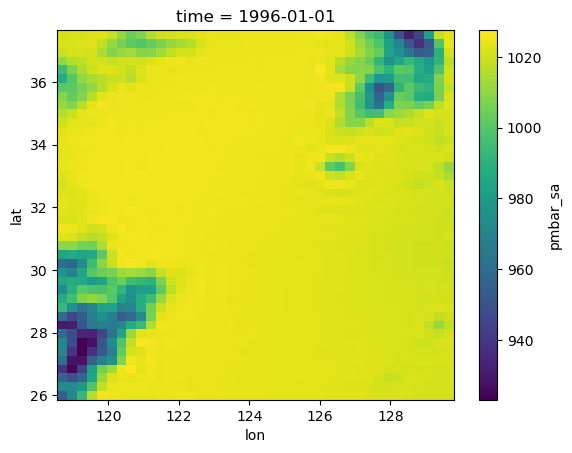

In [30]:
atm_pressure['pmbar_sa'].isel(time=0).plot()
plt.show()

In [81]:
data_full.isel(time=0)#.plot()
#plt.show()

<xarray.DataArray 'wind magnitude' (lat: 42, lon: 40)> Size: 13kB
dask.array<getitem, shape=(42, 40), dtype=float64, chunksize=(42, 40), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 8B 1996-01-01
  * lat      (lat) float64 336B 37.52 37.24 36.96 36.67 ... 26.56 26.28 26.0
  * lon      (lon) float64 320B 118.7 119.0 119.2 119.5 ... 129.1 129.4 129.7

In [14]:
lat_matrix = np.reshape(np.repeat(np.array(relative_hum.lat), 40),(42,40))
np.shape(lat_matrix)

(42, 40)

In [16]:
m_height = np.ones((42,40))*10.0
sal = np.ones((42,40))*35.0
az_in = np.ones((42,40))*45.0
lam_in = np.ones((42,40))*0

In [147]:
C = [0, 100.0,  0.1,   3.00,  14.0,  16.0,  90.0, 1,  1020.0,  35.0,  10.0,  10.0,  10.0,  10.0,  45.0,  45.0]

lam_ = C[0] 
zmax_ = C[1] 
zinc_ = C[2] 
ws_ = C[3] 
tair_ = C[4] 
tsea_ = C[5] 
h_ = C[6] 
hind_ = C[7] 
pr_ = C[8] 
s_ = C[9] 
zu_ = C[10] 
zt_ = C[12] 
zq_ = C[12] 
zp_ = C[13]  
lat_ = C[14] 
az_ = C[15] 


test1 = eng.NAVSLaM_20_191008(lam_, ws_,tair_,tsea_,h_, hind_,pr_,s_,lat_,az_,zu_,zt_,zq_,zp_,zinc_,zmax_,nargout=16)
i=0
out = eng.NAVSLaM_20_191008(lam_in[i,:],np.array(data_full.isel(time=0))[i,:],np.array(tair.isel(time=0))[i,:],np.array(tsea.isel(time=0))[i,:],np.array(relative_hum[rel_hum].isel(time=0))[i,:],2,np.array(atm_pressure['pmbar_sa'].isel(time=0))[i,:],sal[i,:],lat_matrix[i,:],az_in[i,:],m_height[i,:],m_height[i,:],m_height[i,:],m_height[i,:],0.1,100.0,nargout=16)
ustar,tstar,qstar,l,edh,mmin,zprof,u,t,q,p,m,ctsq,cqsq,ctq,cnsq = out[0],out[1],out[2],out[3],out[4],out[5],out[6],out[7],out[8],out[9],out[10],out[11],out[12],out[13],out[14],out[15]

In [19]:
out = eng.NAVSLaM_20_191008(np.ravel(lam_in),np.ravel(np.array(data_full.isel(time=0))),np.ravel(np.array(tair.isel(time=0))),np.ravel(np.array(tsea.isel(time=0))),np.ravel(np.array(relative_hum[rel_hum].isel(time=0))),2,np.ravel(np.array(atm_pressure['pmbar_sa'].isel(time=0))),np.ravel(sal),np.ravel(lat_matrix),np.ravel(az_in),np.ravel(m_height),np.ravel(m_height),np.ravel(m_height),np.ravel(m_height),0.1,100.0,nargout=16)
ustar,tstar,qstar,l,edh,mmin,zprof,u,t,q,p,m,ctsq,cqsq,ctq,cnsq = out[0],out[1],out[2],out[3],out[4],out[5],out[6],out[7],out[8],out[9],out[10],out[11],out[12],out[13],out[14],out[15]

In [60]:
z = np.linspace(0,100,1001)
z

array([  0. ,   0.1,   0.2, ...,  99.8,  99.9, 100. ])

In [64]:
ustar_resh = np.reshape(np.asarray(ustar),(1,1,42,40))
time_ = np.array(data_full.isel(time=0).time)
lat = data_full.lat
lon = data_full.lon
z = np.linspace(0,100,1001)
ustar_cur = xr.DataArray(ustar_resh,dims=['time','z','lat','lon'],coords=[[time_],[z[0]],lat,lon])

ustar_resh

array([[[[ 1.08128776e-01,  2.29767124e-01,  2.95269969e-01, ...,
           9.01032328e-02,  8.40445143e-02,  1.24410937e-01],
         [ 1.07226008e-01,  2.22596726e-01,  2.71337097e-01, ...,
          -9.90000000e+01,  1.34266040e-01,  1.15736246e-01],
         [ 8.97935015e-02,  1.19570956e-01,  1.37483434e-01, ...,
          -9.90000000e+01,  1.04595230e-01,  1.11608025e-01],
         ...,
         [ 3.07403449e-02,  3.90426613e-02,  4.89657505e-02, ...,
           3.15472134e-01,  3.14983356e-01,  3.05939706e-01],
         [ 2.31352746e-02,  4.03953956e-02,  6.23713769e-02, ...,
           3.11530180e-01,  3.03948431e-01,  2.92029420e-01],
         [ 2.71934212e-02,  4.83034357e-02,  6.43974975e-02, ...,
           3.03813080e-01,  2.95156626e-01,  2.83505907e-01]]]])

In [42]:
np.array(tstar)

array([[ 0.03342049, -0.08577427, -0.0595606 , ..., -0.17428575,
        -0.16698004, -0.15832507]])

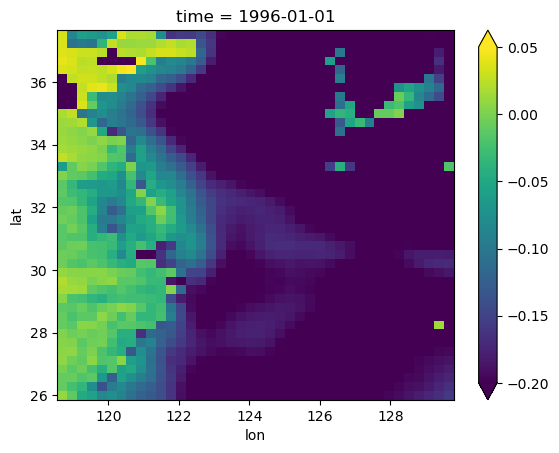

In [45]:
tstar_cur.plot(vmin=-.2,vmax=.05)
plt.show()

In [65]:
np.array(tstar)
tstar_resh = np.reshape(np.asarray(tstar),(1,1,42,40))
tstar_cur = xr.DataArray(tstar_resh,dims=['time','z','lat','lon'],coords=[[time_],[z[0]],lat,lon])

In [66]:

qstar_resh = np.reshape(np.asarray(qstar),(1,1,42,40))
qstar_cur = xr.DataArray(qstar_resh,dims=['time','z','lat','lon'],coords=[[time_],[z[0]],lat,lon])

In [67]:
l

l_resh = np.reshape(np.asarray(l),(1,1,42,40))
l_cur = xr.DataArray(l_resh,dims=['time','z','lat','lon'],coords=[[time_],[z[0]],lat,lon])

In [68]:
edh

edh_resh = np.reshape(np.asarray(edh),(1,1,42,40))
edh_cur = xr.DataArray(edh_resh,dims=['time','z','lat','lon'],coords=[[time_],[z[0]],lat,lon])

In [69]:
mmin
mmin_resh = np.reshape(np.asarray(mmin),(1,1,42,40))
mmin_cur = xr.DataArray(mmin_resh,dims=['time','z','lat','lon'],coords=[[time_],[z[0]],lat,lon])

In [73]:
# zprof_resh = np.reshape(np.array(zprof),(1,1001))
# zprof_cur = xr.DataArray(zprof_resh,dims=['time','z'],coords=[[time_],z])
# zprof_cur

In [77]:
u_resh = np.reshape(np.array(u),(1,1001,42,40))
u_cur = xr.DataArray(u_resh,dims=['time','z','lat','lon'],coords=[[time_],z,lat,lon])
t_resh = np.reshape(np.array(t),(1,1001,42,40))
t_cur = xr.DataArray(t_resh,dims=['time','z','lat','lon'],coords=[[time_],z,lat,lon])
q_resh = np.reshape(np.array(q),(1,1001,42,40))
q_cur = xr.DataArray(q_resh,dims=['time','z','lat','lon'],coords=[[time_],z,lat,lon])
p_resh = np.reshape(np.array(p),(1,1001,42,40))
p_cur = xr.DataArray(p_resh,dims=['time','z','lat','lon'],coords=[[time_],z,lat,lon])
m_resh = np.reshape(np.array(m),(1,1001,42,40))
m_cur = xr.DataArray(m_resh,dims=['time','z','lat','lon'],coords=[[time_],z,lat,lon])
ctsq_resh = np.reshape(np.array(ctsq),(1,1001,42,40))
ctsq_cur = xr.DataArray(ctsq_resh,dims=['time','z','lat','lon'],coords=[[time_],z,lat,lon])
cqsq_resh = np.reshape(np.array(cqsq),(1,1001,42,40))
cqsq_cur = xr.DataArray(cqsq_resh,dims=['time','z','lat','lon'],coords=[[time_],z,lat,lon])

ctq_resh = np.reshape(np.array(ctq),(1,1001,42,40))
ctq_cur = xr.DataArray(ctq_resh,dims=['time','z','lat','lon'],coords=[[time_],z,lat,lon])

cnsq_resh = np.reshape(np.array(cnsq),(1,1001,42,40))
cnsq_cur = xr.DataArray(cnsq_resh,dims=['time','z','lat','lon'],coords=[[time_],z,lat,lon])

In [51]:
np.shape(t)

(1001, 1680)

In [78]:
np.shape(q)

(1001, 1680)

In [79]:
np.shape(p)

(1001, 1680)

In [52]:
np.shape(m)

(1001, 1680)

In [54]:
np.shape(ctsq)

(1001, 1680)

In [55]:
np.shape(cqsq)


(1001, 1680)

In [57]:

np.shape(ctq)
np.shape(cnsq)

(1001, 1680)

In [102]:
time_ = np.array(data_full.sel(time='1996').time)
len(time_)

8784

In [25]:
np.array(data_full.time == data_full.sel(time='1996-07').time[0])

array([False, False, False, ..., False, False, False])

In [26]:
np.nonzero(np.array(data_full.time == data_full.sel(time='1996-07').time[0]))

(array([4368], dtype=int64),)

In [27]:
#for full time series
z = np.linspace(0,100,1001)

lat = data_full.lat
lon = data_full.lon

for i in tqdm(range(4368,4368+24*7)):#len(data_full.time))):
    time_ = np.array(data_full.isel(time=i).time)
    out = eng.NAVSLaM_20_191008(np.ravel(lam_in),np.ravel(np.array(data_full.isel(time=i))),np.ravel(np.array(tair.isel(time=i))),np.ravel(np.array(tsea.isel(time=i))),np.ravel(np.array(relative_hum[rel_hum].isel(time=i))),2,np.ravel(np.array(atm_pressure['pmbar_sa'].isel(time=i))),np.ravel(sal),np.ravel(lat_matrix),np.ravel(az_in),np.ravel(m_height),np.ravel(m_height),np.ravel(m_height),np.ravel(m_height),0.1,100.0,nargout=16)
    ustar,tstar,qstar,l,edh,mmin,zprof,u,t,q,p,m,ctsq,cqsq,ctq,cnsq = out[0],out[1],out[2],out[3],out[4],out[5],out[6],out[7],out[8],out[9],out[10],out[11],out[12],out[13],out[14],out[15]
    ustar_resh = np.reshape(np.asarray(ustar),(1,1,42,40))
    ustar_cur = xr.DataArray(ustar_resh,dims=['time','z','lat','lon'],coords=[[time_],[z[0]],lat,lon],name='ustar')
    tstar_resh = np.reshape(np.asarray(tstar),(1,1,42,40))
    tstar_cur = xr.DataArray(tstar_resh,dims=['time','z','lat','lon'],coords=[[time_],[z[0]],lat,lon],name='tstar')
    qstar_resh = np.reshape(np.asarray(qstar),(1,1,42,40))
    qstar_cur = xr.DataArray(qstar_resh,dims=['time','z','lat','lon'],coords=[[time_],[z[0]],lat,lon],name='qstar')
    l_resh = np.reshape(np.asarray(l),(1,1,42,40))
    l_cur = xr.DataArray(l_resh,dims=['time','z','lat','lon'],coords=[[time_],[z[0]],lat,lon],name='l')
    edh_resh = np.reshape(np.asarray(edh),(1,1,42,40))
    edh_cur = xr.DataArray(edh_resh,dims=['time','z','lat','lon'],coords=[[time_],[z[0]],lat,lon],name='edh')
    mmin_resh = np.reshape(np.asarray(mmin),(1,1,42,40))
    mmin_cur = xr.DataArray(mmin_resh,dims=['time','z','lat','lon'],coords=[[time_],[z[0]],lat,lon],name='mmin')
    u_resh = np.reshape(np.array(u),(1,1001,42,40))
    u_cur = xr.DataArray(u_resh,dims=['time','z','lat','lon'],coords=[[time_],z,lat,lon],name='u')
    t_resh = np.reshape(np.array(t),(1,1001,42,40))
    t_cur = xr.DataArray(t_resh,dims=['time','z','lat','lon'],coords=[[time_],z,lat,lon],name='t')
    q_resh = np.reshape(np.array(q),(1,1001,42,40))
    q_cur = xr.DataArray(q_resh,dims=['time','z','lat','lon'],coords=[[time_],z,lat,lon],name='q')
    p_resh = np.reshape(np.array(p),(1,1001,42,40))
    p_cur = xr.DataArray(p_resh,dims=['time','z','lat','lon'],coords=[[time_],z,lat,lon],name='p')
    m_resh = np.reshape(np.array(m),(1,1001,42,40))
    m_cur = xr.DataArray(m_resh,dims=['time','z','lat','lon'],coords=[[time_],z,lat,lon],name='m')
    ctsq_resh = np.reshape(np.array(ctsq),(1,1001,42,40))
    ctsq_cur = xr.DataArray(ctsq_resh,dims=['time','z','lat','lon'],coords=[[time_],z,lat,lon],name='ctsq')
    cqsq_resh = np.reshape(np.array(cqsq),(1,1001,42,40))
    cqsq_cur = xr.DataArray(cqsq_resh,dims=['time','z','lat','lon'],coords=[[time_],z,lat,lon],name='cqsq')
    ctq_resh = np.reshape(np.array(ctq),(1,1001,42,40))
    ctq_cur = xr.DataArray(ctq_resh,dims=['time','z','lat','lon'],coords=[[time_],z,lat,lon],name='ctq')
    cnsq_resh = np.reshape(np.array(cnsq),(1,1001,42,40))
    cnsq_cur = xr.DataArray(cnsq_resh,dims=['time','z','lat','lon'],coords=[[time_],z,lat,lon],name='cnsq')
    navslam_data = xr.merge([ustar_cur,tstar_cur,qstar_cur,l_cur,edh_cur,mmin_cur,u_cur,t_cur,q_cur,p_cur,m_cur,ctsq_cur,cqsq_cur,ctq_cur,cnsq_cur])
    navslam_data.to_netcdf('D:/era5_data/navslam_output2/navslam_out_'+str(i).zfill(7)+'.nc')

  0%|          | 0/168 [00:00<?, ?it/s]

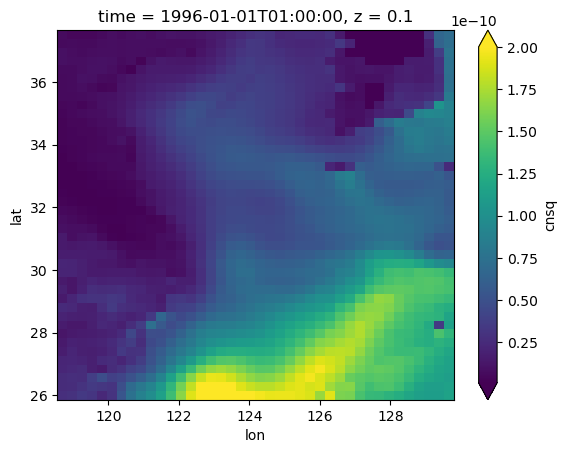

In [98]:
navslam_data['cnsq'].isel(time=0,z=1).plot(vmin=1e-12,vmax=2e-10)
plt.show()

In [17]:
nav_files1, nav_filepaths1 = tools.get_data_paths_from_binary('D:/era5_data/','navslam_output/',file_end='nc')
nav_files2, nav_filepaths2 = tools.get_data_paths_from_binary('D:/era5_data/','navslam_output2/',file_end='nc')


In [20]:
navslam_output1 = xr.open_mfdataset(nav_filepaths1[0:24*7])

In [21]:
navslam_output2 = xr.open_mfdataset(nav_filepaths2)

In [118]:
navslam_output_current

<xarray.Dataset> Size: 34GB
Dimensions:  (time: 168, z: 1001, lat: 42, lon: 40)
Coordinates:
  * z        (z) float64 8kB 0.0 0.1 0.2 0.3 0.4 ... 99.6 99.7 99.8 99.9 100.0
  * lat      (lat) float64 336B 37.52 37.24 36.96 36.67 ... 26.56 26.28 26.0
  * lon      (lon) float64 320B 118.7 119.0 119.2 119.5 ... 129.1 129.4 129.7
  * time     (time) datetime64[ns] 1kB 1996-01-01 ... 1996-01-07T23:00:00
Data variables: (12/15)
    ustar    (time, z, lat, lon) float64 2GB dask.array<chunksize=(1, 1001, 42, 40), meta=np.ndarray>
    tstar    (time, z, lat, lon) float64 2GB dask.array<chunksize=(1, 1001, 42, 40), meta=np.ndarray>
    qstar    (time, z, lat, lon) float64 2GB dask.array<chunksize=(1, 1001, 42, 40), meta=np.ndarray>
    l        (time, z, lat, lon) float64 2GB dask.array<chunksize=(1, 1001, 42, 40), meta=np.ndarray>
    edh      (time, z, lat, lon) float64 2GB dask.array<chunksize=(1, 1001, 42, 40), meta=np.ndarray>
    mmin     (time, z, lat, lon) float64 2GB dask.array<chunksize=(1, 1001, 42, 40), meta=np.ndarray>
    ...       ...
    p        (time, z, lat, lon) float64 2GB dask.array<chunksize=(1, 1001, 42, 40), meta=np.ndarray>
    m        (time, z, lat, lon) float64 2GB dask.array<chunksize=(1, 1001, 42, 40), meta=np.ndarray>
    ctsq     (time, z, lat, lon) float64 2GB dask.array<chunksize=(1, 1001, 42, 40), meta=np.ndarray>
    cqsq     (time, z, lat, lon) float64 2GB dask.array<chunksize=(1, 1001, 42, 40), meta=np.ndarray>
    ctq      (time, z, lat, lon) float64 2GB dask.array<chunksize=(1, 1001, 42, 40), meta=np.ndarray>
    cnsq     (time, z, lat, lon) float64 2GB dask.array<chunksize=(1, 1001, 42, 40), meta=np.ndarray>

In [22]:
nav_at_I1 = navslam_output1.sel(lon=I_ORS_lon,lat=I_ORS_lat,method='nearest')
nav_at_G1 = navslam_output1.sel(lon=G_ORS_lon,lat=G_ORS_lat,method='nearest')
#nav_at_S1 = navslam_output1.sel(lon=S_ORS_lon,lat=S_ORS_lat,method='nearest')

nav_at_I2 = navslam_output2.sel(lon=I_ORS_lon,lat=I_ORS_lat,method='nearest')
nav_at_G2 = navslam_output2.sel(lon=G_ORS_lon,lat=G_ORS_lat,method='nearest')
#nav_at_S1 = navslam_output1.sel(lon=S_ORS_lon,lat=S_ORS_lat,method='nearest')

In [32]:
navslam_output_current['ustar'].isel(z=0)#.where(navslam_output_current['ustar']>-100).mean(dim='time',skipna=True).plot()
#plt.show()

<xarray.DataArray 'ustar' (time: 168, lat: 42, lon: 40)> Size: 2MB
dask.array<getitem, shape=(168, 42, 40), dtype=float64, chunksize=(1, 42, 40), chunktype=numpy.ndarray>
Coordinates:
    z        float64 8B 0.0
  * lat      (lat) float64 336B 37.52 37.24 36.96 36.67 ... 26.56 26.28 26.0
  * lon      (lon) float64 320B 118.7 119.0 119.2 119.5 ... 129.1 129.4 129.7
  * time     (time) datetime64[ns] 1kB 1996-07-01 ... 1996-07-07T23:00:00

In [37]:
#navslam_output_current = navslam_output_current.where(np.abs(navslam_output_current)<5)

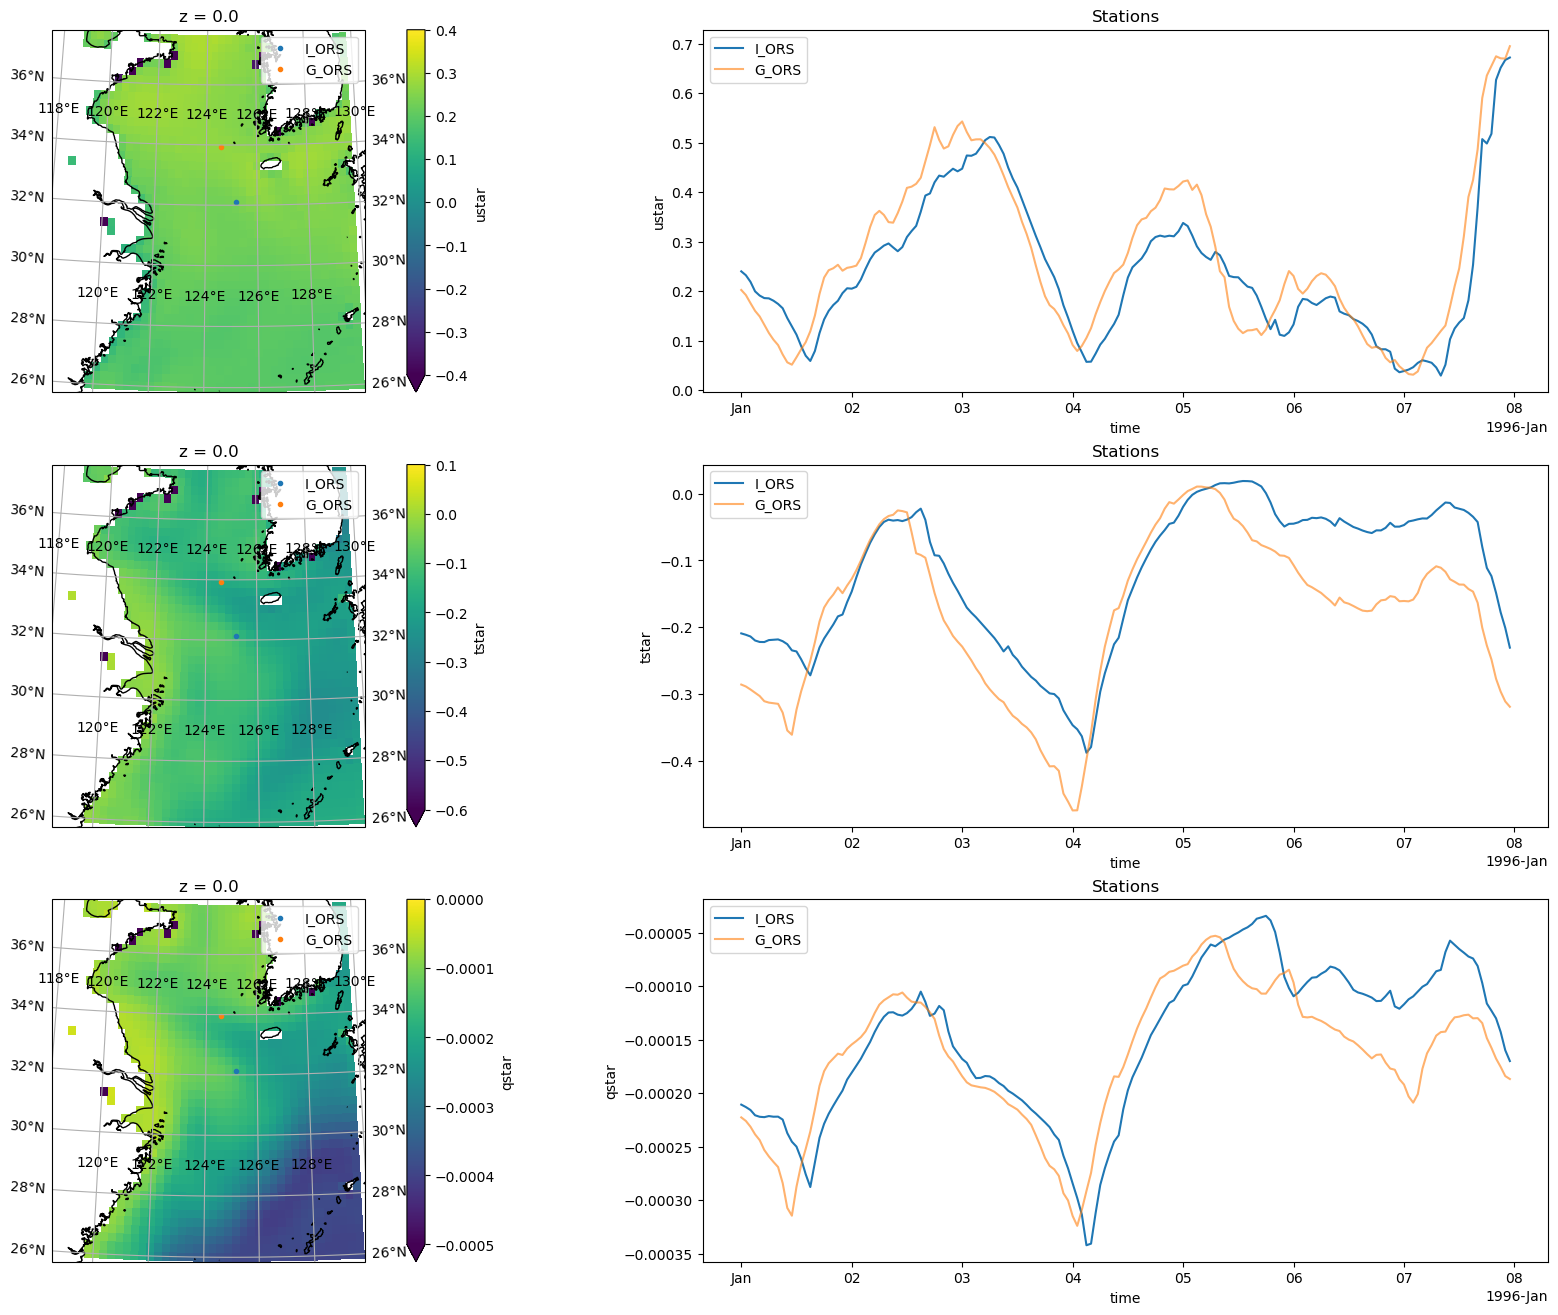

In [23]:
#jan
plt.figure(figsize=(24,16))

ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=1,projection=ccrs.LambertConformal(central_longitude=125))
#labelz_temp = 'Temperature [$^\circ$C]'
#skin temp
navslam_output1['ustar'].isel(z=0).mean(dim='time',skipna=True).where(land_mask).plot(vmin=-.4,vmax=.4,ax=ax1,transform=ccrs.PlateCarree())
ax1.plot(I_ORS_lon,I_ORS_lat,'.',label='I_ORS',transform=ccrs.PlateCarree())
ax1.plot(G_ORS_lon,G_ORS_lat,'.',label='G_ORS',transform=ccrs.PlateCarree())
#ax1.plot(S_ORS_lon,S_ORS_lat,'.',label='S_ORS',transform=ccrs.PlateCarree())
#ax1.set_title('Skin Temperature')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.legend()


ax2 = plt.subplot2grid((3, 2), (0, 1), colspan=1)
navslam_output1['ustar'].isel(z=0).sel(lon=I_ORS_lon,lat=I_ORS_lat,method='nearest').plot(ax=ax2,label='I_ORS')
navslam_output1['ustar'].isel(z=0).sel(lon=G_ORS_lon,lat=G_ORS_lat,method='nearest').plot(ax=ax2,label='G_ORS',alpha=.6)
#navslam_output_current['ustar'].isel(z=0).sel(lon=S_ORS_lon,lat=S_ORS_lat,method='nearest').plot(ax=ax2,label='S_ORS',alpha=.6)
ax2.set_ylabel('ustar')
#ax2.set_ylim([-.4,.4])
ax2.legend()

ax2.set_title('Stations')


ax3 = plt.subplot2grid((3, 2), (1, 0), colspan=1,projection=ccrs.LambertConformal(central_longitude=125))
navslam_output1['tstar'].isel(z=0).mean(dim='time',skipna=True).where(land_mask).plot(vmax=.1,vmin=-.6,ax=ax3,transform=ccrs.PlateCarree())
ax3.plot(I_ORS_lon,I_ORS_lat,'.',label='I_ORS',transform=ccrs.PlateCarree())
ax3.plot(G_ORS_lon,G_ORS_lat,'.',label='G_ORS',transform=ccrs.PlateCarree())
#ax3.plot(S_ORS_lon,S_ORS_lat,'.',label='S_ORS',transform=ccrs.PlateCarree())
#ax3.set_title('Air Temperature at 10 m')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
ax3.legend()


ax4 = plt.subplot2grid((3, 2), (1, 1), colspan=1)
ax4.set_title('Stations')


navslam_output1['tstar'].isel(z=0).sel(lon=I_ORS_lon,lat=I_ORS_lat,method='nearest').plot(ax=ax4,label='I_ORS')
navslam_output1['tstar'].isel(z=0).sel(lon=G_ORS_lon,lat=G_ORS_lat,method='nearest').plot(ax=ax4,label='G_ORS',alpha=.6)
#navslam_output_current['tstar'].isel(z=0).sel(lon=S_ORS_lon,lat=S_ORS_lat,method='nearest').plot(ax=ax4,label='S_ORS',alpha=.6)
ax4.set_ylabel('tstar')
#ax4.set_ylim([-.6,.1])
ax4.legend()

ax5 = plt.subplot2grid((3, 2), (2, 0), colspan=1,projection=ccrs.LambertConformal(central_longitude=125))
navslam_output1['qstar'].isel(z=0).mean(dim='time',skipna=True).where(land_mask).plot(vmax=0,vmin=-5e-4,ax=ax5,transform=ccrs.PlateCarree())
ax5.plot(I_ORS_lon,I_ORS_lat,'.',label='I_ORS',transform=ccrs.PlateCarree())
ax5.plot(G_ORS_lon,G_ORS_lat,'.',label='G_ORS',transform=ccrs.PlateCarree())
#ax5.plot(S_ORS_lon,S_ORS_lat,'.',label='S_ORS',transform=ccrs.PlateCarree())
#ax5.set_title('Air-Sea Temperature Difference ')
ax5.set_xlabel('Longitude')
ax5.set_ylabel('Latitude')
ax5.legend()


ax6 = plt.subplot2grid((3, 2), (2, 1), colspan=1)
navslam_output1['qstar'].isel(z=0).sel(lon=I_ORS_lon,lat=I_ORS_lat,method='nearest').plot(ax=ax6,label='I_ORS')
navslam_output1['qstar'].isel(z=0).sel(lon=G_ORS_lon,lat=G_ORS_lat,method='nearest').plot(ax=ax6,label='G_ORS',alpha=.6)
#navslam_output_current['qstar'].isel(z=0).sel(lon=S_ORS_lon,lat=S_ORS_lat,method='nearest').plot(ax=ax6,label='S_ORS',alpha=.4)
ax6.set_ylabel('qstar')
#ax6.set_ylim([-5e-4,0])
ax6.legend()
ax6.set_title('Stations')

ax4.set_title('Stations')

ax1.coastlines()
ax3.coastlines()
ax5.coastlines()

gl1 = ax1.gridlines(draw_labels=True)
gl1.xformatter = LONGITUDE_FORMATTER
gl1.yformatter = LATITUDE_FORMATTER

gl3 = ax3.gridlines(draw_labels=True)
gl3.xformatter = LONGITUDE_FORMATTER
gl3.yformatter = LATITUDE_FORMATTER

gl5 = ax5.gridlines(draw_labels=True)
gl5.xformatter = LONGITUDE_FORMATTER
gl5.yformatter = LATITUDE_FORMATTER


plt.show()

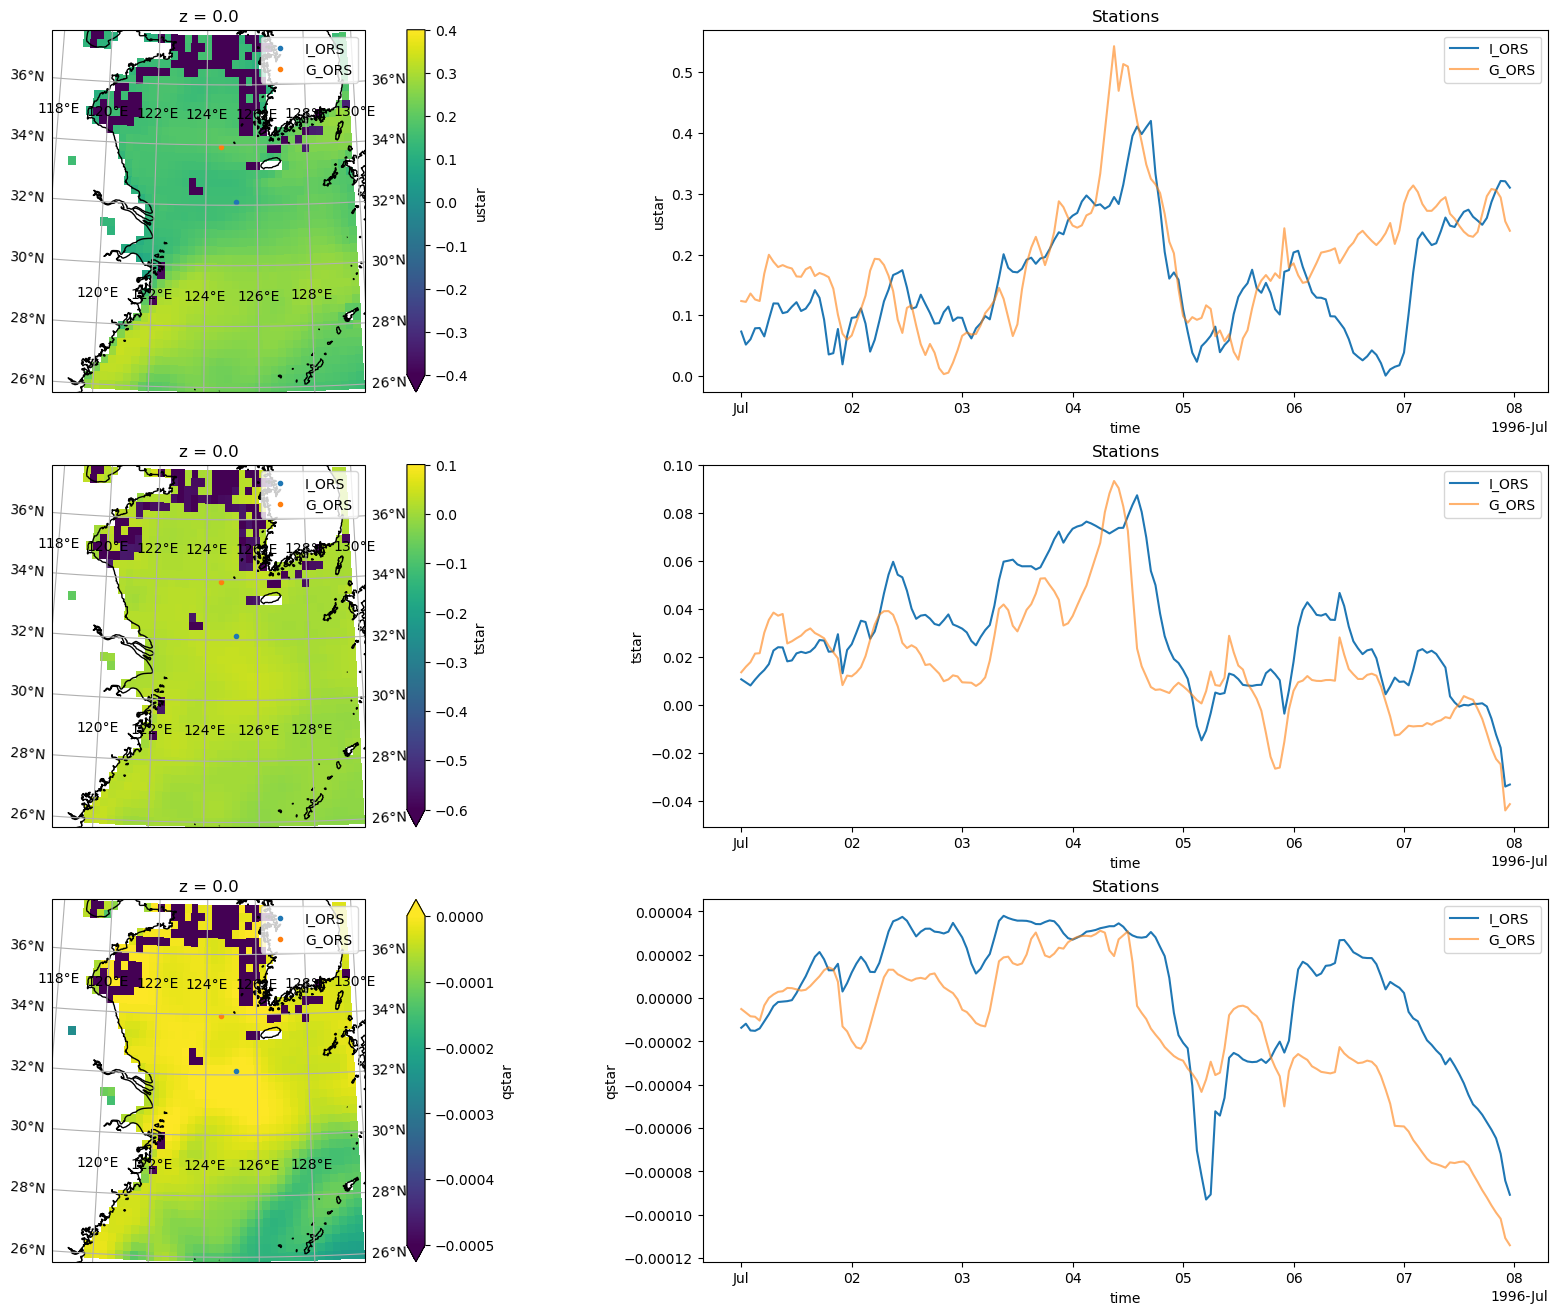

In [24]:
#july
plt.figure(figsize=(24,16))

ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=1,projection=ccrs.LambertConformal(central_longitude=125))
#labelz_temp = 'Temperature [$^\circ$C]'
#skin temp
navslam_output2['ustar'].isel(z=0).mean(dim='time',skipna=True).where(land_mask).plot(vmin=-.4,vmax=.4,ax=ax1,transform=ccrs.PlateCarree())
ax1.plot(I_ORS_lon,I_ORS_lat,'.',label='I_ORS',transform=ccrs.PlateCarree())
ax1.plot(G_ORS_lon,G_ORS_lat,'.',label='G_ORS',transform=ccrs.PlateCarree())
#ax1.plot(S_ORS_lon,S_ORS_lat,'.',label='S_ORS',transform=ccrs.PlateCarree())
#ax1.set_title('Skin Temperature')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.legend()


ax2 = plt.subplot2grid((3, 2), (0, 1), colspan=1)
navslam_output2['ustar'].isel(z=0).sel(lon=I_ORS_lon,lat=I_ORS_lat,method='nearest').plot(ax=ax2,label='I_ORS')
navslam_output2['ustar'].isel(z=0).sel(lon=G_ORS_lon,lat=G_ORS_lat,method='nearest').plot(ax=ax2,label='G_ORS',alpha=.6)
#navslam_output_current['ustar'].isel(z=0).sel(lon=S_ORS_lon,lat=S_ORS_lat,method='nearest').plot(ax=ax2,label='S_ORS',alpha=.6)
ax2.set_ylabel('ustar')
#ax2.set_ylim([-.4,.4])
ax2.legend()

ax2.set_title('Stations')


ax3 = plt.subplot2grid((3, 2), (1, 0), colspan=1,projection=ccrs.LambertConformal(central_longitude=125))
navslam_output2['tstar'].isel(z=0).mean(dim='time',skipna=True).where(land_mask).plot(vmax=.1,vmin=-.6,ax=ax3,transform=ccrs.PlateCarree())
ax3.plot(I_ORS_lon,I_ORS_lat,'.',label='I_ORS',transform=ccrs.PlateCarree())
ax3.plot(G_ORS_lon,G_ORS_lat,'.',label='G_ORS',transform=ccrs.PlateCarree())
#ax3.plot(S_ORS_lon,S_ORS_lat,'.',label='S_ORS',transform=ccrs.PlateCarree())
#ax3.set_title('Air Temperature at 10 m')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
ax3.legend()


ax4 = plt.subplot2grid((3, 2), (1, 1), colspan=1)
ax4.set_title('Stations')


navslam_output2['tstar'].isel(z=0).sel(lon=I_ORS_lon,lat=I_ORS_lat,method='nearest').plot(ax=ax4,label='I_ORS')
navslam_output2['tstar'].isel(z=0).sel(lon=G_ORS_lon,lat=G_ORS_lat,method='nearest').plot(ax=ax4,label='G_ORS',alpha=.6)
#navslam_output_current['tstar'].isel(z=0).sel(lon=S_ORS_lon,lat=S_ORS_lat,method='nearest').plot(ax=ax4,label='S_ORS',alpha=.6)
ax4.set_ylabel('tstar')
#ax4.set_ylim([-.6,.1])
ax4.legend()

ax5 = plt.subplot2grid((3, 2), (2, 0), colspan=1,projection=ccrs.LambertConformal(central_longitude=125))
navslam_output2['qstar'].isel(z=0).mean(dim='time',skipna=True).where(land_mask).plot(vmax=0,vmin=-5e-4,ax=ax5,transform=ccrs.PlateCarree())
ax5.plot(I_ORS_lon,I_ORS_lat,'.',label='I_ORS',transform=ccrs.PlateCarree())
ax5.plot(G_ORS_lon,G_ORS_lat,'.',label='G_ORS',transform=ccrs.PlateCarree())
#ax5.plot(S_ORS_lon,S_ORS_lat,'.',label='S_ORS',transform=ccrs.PlateCarree())
#ax5.set_title('Air-Sea Temperature Difference ')
ax5.set_xlabel('Longitude')
ax5.set_ylabel('Latitude')
ax5.legend()


ax6 = plt.subplot2grid((3, 2), (2, 1), colspan=1)
navslam_output2['qstar'].isel(z=0).sel(lon=I_ORS_lon,lat=I_ORS_lat,method='nearest').plot(ax=ax6,label='I_ORS')
navslam_output2['qstar'].isel(z=0).sel(lon=G_ORS_lon,lat=G_ORS_lat,method='nearest').plot(ax=ax6,label='G_ORS',alpha=.6)
#navslam_output_current['qstar'].isel(z=0).sel(lon=S_ORS_lon,lat=S_ORS_lat,method='nearest').plot(ax=ax6,label='S_ORS',alpha=.4)
ax6.set_ylabel('qstar')
#ax6.set_ylim([-5e-4,0])
ax6.legend()
ax6.set_title('Stations')

ax4.set_title('Stations')

ax1.coastlines()
ax3.coastlines()
ax5.coastlines()

gl1 = ax1.gridlines(draw_labels=True)
gl1.xformatter = LONGITUDE_FORMATTER
gl1.yformatter = LATITUDE_FORMATTER

gl3 = ax3.gridlines(draw_labels=True)
gl3.xformatter = LONGITUDE_FORMATTER
gl3.yformatter = LATITUDE_FORMATTER

gl5 = ax5.gridlines(draw_labels=True)
gl5.xformatter = LONGITUDE_FORMATTER
gl5.yformatter = LATITUDE_FORMATTER


plt.show()

In [30]:
eds1 = navslam_output1['m'].isel(z=0) - navslam_output1['mmin'].isel(z=0)

eds2 = navslam_output2['m'].isel(z=0)- navslam_output2['mmin'].isel(z=0)

In [61]:
np.sqrt(32+25)

7.54983443527075

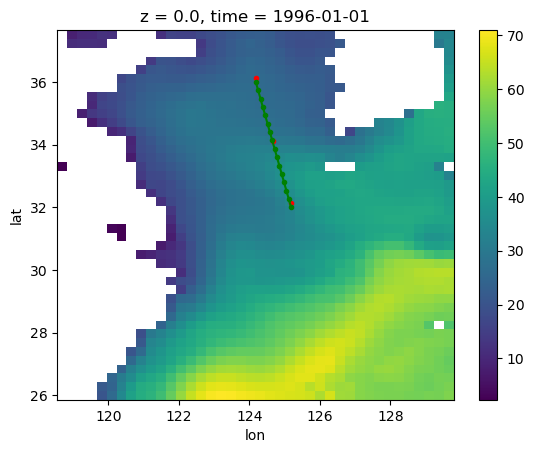

In [62]:
lonline = np.linspace(I_ORS_lon,I_ORS_lon-1,16)
latline = np.linspace(32,36,16)
eds1.isel(time=0).where(land_mask).plot()
plt.plot(I_ORS_lon,I_ORS_lat,'.',c='red')
plt.plot(I_ORS_lon-.5,I_ORS_lat+2,'.',c='red')
plt.plot(I_ORS_lon-1,I_ORS_lat+4,'.',c='red')
plt.plot(lonline,latline,c='g',marker='.')
plt.show()
# eds2.mean(dim='time').where(land_mask).plot()
# plt.show()

In [70]:
Lat,Lon = np.meshgrid(eds1.lat,eds1.lon)
points = np.column_stack([np.ravel(Lon), np.ravel(Lat)])
sampled_transect_eds1 = griddata(points, np.array(eds1.isel(time=0)).ravel(), (lonline, latline))



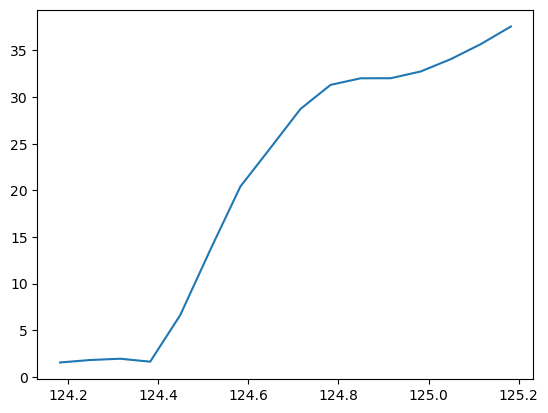

In [72]:
plt.plot(lonline,sampled_transect_eds1)
plt.show()

In [49]:
eds2

<xarray.DataArray (time: 168, lat: 42, lon: 40)> Size: 2MB
dask.array<sub, shape=(168, 42, 40), dtype=float64, chunksize=(1, 42, 40), chunktype=numpy.ndarray>
Coordinates:
    z        float64 8B 0.0
  * lat      (lat) float64 336B 37.52 37.24 36.96 36.67 ... 26.56 26.28 26.0
  * lon      (lon) float64 320B 118.7 119.0 119.2 119.5 ... 129.1 129.4 129.7
  * time     (time) datetime64[ns] 1kB 1996-07-01 ... 1996-07-07T23:00:00

In [48]:
plt.figure(figsize=(24,16),transform=ccrs.LambertConformal(central_longitude=125))
eds2.mean(dim='time').where(land_mask).plot(transform=ccrs.PlateCarree())

plt.plot(I_ORS_lon,I_ORS_lat,'.',label='I_ORS',transform=ccrs.PlateCarree())
plt.plot(G_ORS_lon,G_ORS_lat,'.',label='G_ORS',transform=ccrs.PlateCarree())
plt.show()

ValueError: Axes should be an instance of GeoAxes, got <class 'matplotlib.axes._axes.Axes'>

In [ ]:
plt.figure(figsize=(24,16),projection=ccrs.LambertConformal(central_longitude=125))

navslam_output2['ustar'].isel(z=0).mean(dim='time',skipna=True).where(land_mask).plot(vmin=-.4,vmax=.4,transform=ccrs.PlateCarree())
plt.plot(I_ORS_lon,I_ORS_lat,'.',label='I_ORS',transform=ccrs.PlateCarree())
plt.plot(G_ORS_lon,G_ORS_lat,'.',label='G_ORS',transform=ccrs.PlateCarree())
plt.show()

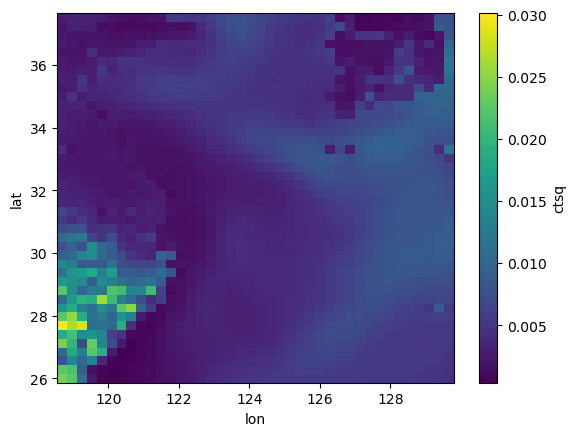

In [141]:
navslam_output_current['ctsq'].where(np.abs(navslam_output_current['ctsq'])<.3).mean(dim='time',skipna=True).mean(dim='z',skipna=True).plot()
plt.show()

In [ ]:
ustar**2*air_rho #
*-1 to S and L heat flux
#air_rho*cp(heat capacity)(1005)+l

#~1.3/1.2 N/m2

#W/m2

In [ ]:
lowcldcov_sa

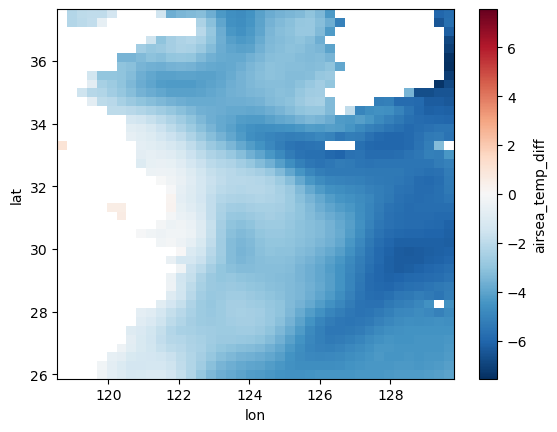

In [39]:
air_sea_temp_diff.sel(time=slice('1996-01-01','1996-01-07')).mean(dim='time',skipna=True).where(land_mask).plot()
plt.show()

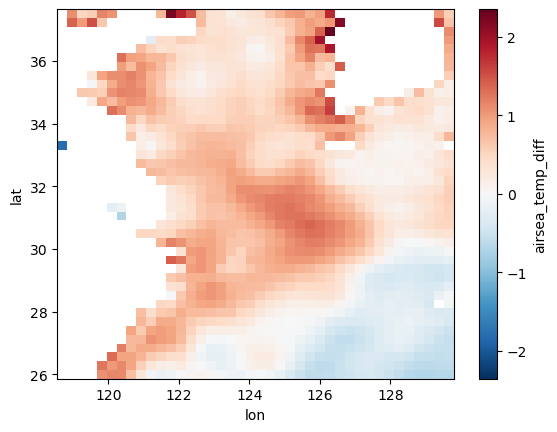

In [40]:
air_sea_temp_diff.sel(time=slice('1996-07-01','1996-07-07')).mean(dim='time',skipna=True).where(land_mask).plot()
plt.show()

In [9]:
rho = airsea.atmosphere.air_dens()

Cp = 1005
L = 2.5e6
SHF = rho*Cp*ustar*tstar
LHF = rho*L*ustar*qstar


TypeError: air_dens() missing 2 required positional arguments: 'Ta' and 'rh'

In [64]:
air_sea_temp_diff.sel(time=slice('1996-07-01','1996-07-08'))#.plot()
#plt.show()

<xarray.DataArray 'airsea_temp_diff' (time: 192, lat: 42, lon: 40)> Size: 3MB
dask.array<getitem, shape=(192, 42, 40), dtype=float64, chunksize=(192, 42, 40), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2kB 1996-07-01 ... 1996-07-08T23:00:00
  * lat      (lat) float64 336B 37.52 37.24 36.96 36.67 ... 26.56 26.28 26.0
  * lon      (lon) float64 320B 118.7 119.0 119.2 119.5 ... 129.1 129.4 129.7

In [ ]:
# Input parameters:
# %    lambda - Wavelength (microns) or radio frequency flag (lambda = 0)
# %             Can be scalar or array for optical wavelength applications
# %             Must be a scalar value of 0 for radio frequency applications
# %    ws     - Wind speed (m/s)
# %    tair   - Air temperature (C)
# %    tsea   - Sea temperature (C)
# %    h      - Humidity parameter, either relative or specific humidity
# %    hflag  - Humidity flag, indicates humidity parameter for h input: 
# %             1 = Relative humidity (%), 2 = Specific humidity (kg/kg)
# %             Must be a scalar value
# %    pr     - Atmospheric pressure (hPa) - default is 1013 hPa
# %    s      - Ocean salinity (PSU)
# %             Can be scalar or array input, default value is 35 PSU
# %    lat    - Latitude in decimal degrees (positive north, negative south)
# %             Can be scalar or array input, default value is 40 degrees
# %    az     - Azimuth of propagation in degrees clockwise from north
# %             Can be scalar or array input, default value is 45 degrees
# %    zu     - Wind speed measurement/forecast height (m)
# %             Can be scalar or array input
# %    zt     - Air temperature measurement/forecast height (m)
# %             Can be scalar or array input
# %    zh     - Humidity measurement/forecast height (m)
# %             Can be scalar or array input
# %    zp     - Atmospheric pressure measurement/forecast height (m)
# %             Can be scalar or array input
# %    zinc   - Height array increment (scalar) for computing profiles (m)
# %             or a pre-defined height array for output vertical profiles
# %    zmax   - Maximum height for computing profiles (m) - scalar
# %             Not used if zinc is a pre-defined height array